<a href="https://colab.research.google.com/github/callealbrecht/Fake-News-Detection-with-Machine-Learning/blob/main/Fake_News_Detection_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project I build a text classifier that predicts whether a news article is **fake** or **real**.

**Steps:**
1. Load and explore a labeled fake/real news dataset.
2. Preprocess the news text.
3. Convert text to numerical features using TF-IDF.
4. Train and compare at least two models (Logistic Regression, Naive Bayes).
5. Evaluate using accuracy, precision, recall, F1, and a confusion matrix.
6. Inspect which words are most associated with fake vs real news.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
import io
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

### Loading the Dataset
In this step, I upload the Fake.csv and True.csv files from the Kaggle Fake/Real News dataset. Each file contains news articles that belong to either the fake or real category. I load both files into separate DataFrames for further processing.

In [4]:
print("Upload Fake.csv and True.csv from the dataset.")
uploaded = files.upload()

uploaded_files = list(uploaded.keys())
print("Uploaded files:", uploaded_files)

Upload Fake.csv and True.csv from the dataset.


Saving Fake.csv to Fake (1).csv
Saving True.csv to True.csv
Uploaded files: ['Fake (1).csv', 'True.csv']


### Combining and Labeling Data
I merge the Fake and True datasets into a single DataFrame and add a new column called "label" to clearly distinguish between fake and real news. This results in one unified dataset that can be used for model training.

In [5]:
fake_name = uploaded_files[0]
true_name = uploaded_files[1]

df_fake = pd.read_csv(io.BytesIO(uploaded[fake_name]))
df_true = pd.read_csv(io.BytesIO(uploaded[true_name]))

print("Fake columns:", df_fake.columns.tolist())
print("True columns:", df_true.columns.tolist())

# ['title', 'text', 'subject', 'date']
df_fake['label'] = 'FAKE'
df_true['label'] = 'REAL'

df = pd.concat([df_fake, df_true]).reset_index(drop=True)
df.head()

Fake columns: ['title', 'text', 'subject', 'date']
True columns: ['title', 'text', 'subject', 'date']


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE


Number of rows: 44898

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB
None

Class distribution:
label
FAKE    23481
REAL    21417
Name: count, dtype: int64


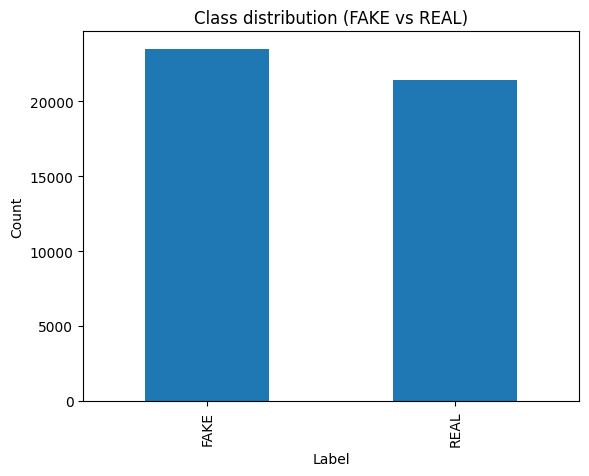

In [6]:
print("Number of rows:", len(df))
print("\nBasic info:")
print(df.info())

print("\nClass distribution:")
print(df['label'].value_counts())

df['label'].value_counts().plot(kind='bar')
plt.title("Class distribution (FAKE vs REAL)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Text Cleaning and Preprocessing
I create a combined text field by merging each article's title and main content. Then I clean the text by converting it to lowercase, removing URLs, punctuation, digits, and extra whitespace.

In [7]:
df['title'] = df['title'].astype(str)
df['text'] = df['text'].astype(str)

df['content'] = df['title'] + ' ' + df['text']

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)  # remove URLs
    text = re.sub(r'\d+', ' ', text)               # remove digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)       # remove punctuation etc.
    text = re.sub(r'\s+', ' ', text).strip()       # collapse spaces
    return text

df['content_clean'] = df['content'].apply(clean_text)
df[['label', 'content_clean']].head()

,label,content_clean
0,FAKE,donald trump sends out embarrassing new year s...
1,FAKE,drunk bragging trump staffer started russian c...
2,FAKE,sheriff david clarke becomes an internet joke ...
3,FAKE,trump is so obsessed he even has obama s name ...
4,FAKE,pope francis just called out donald trump duri...


### Data Analysis
I examine the dataset’s size, inspect the distribution of fake and real news, and analyze text length statistics.


count    44898.000000
mean      2464.512695
std       2102.544250
min          0.000000
25%       1269.000000
50%       2195.000000
75%       3082.000000
max      50420.000000
Name: text_len, dtype: float64


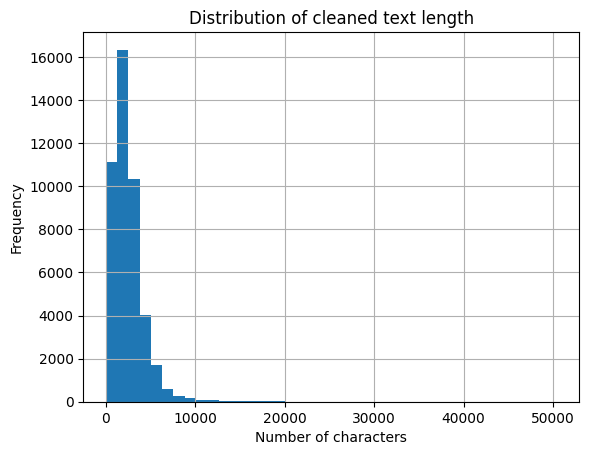

In [8]:
df['text_len'] = df['content_clean'].apply(len)

print(df['text_len'].describe())

df['text_len'].hist(bins=40)
plt.title("Distribution of cleaned text length")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()

###Encoding Labels
I convert the textual labels (FAKE and REAL) into numerical values using LabelEncoder. Machine-learning algorithms require numeric inputs, so this prepares the labels for model training.


In [9]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print("Label classes:", list(label_encoder.classes_))
df[['label', 'label_encoded']].head()

Label classes: ['FAKE', 'REAL']


,label,label_encoded
0,FAKE,0
1,FAKE,0
2,FAKE,0
3,FAKE,0
4,FAKE,0


### Splitting Into Training and Test Sets
I split the dataset into training and test sets, using 80% of the data for training and 20% for testing. This ensures that I can evaluate the model on data it has not seen before.


In [10]:
X = df['content_clean']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test)

(35918, 8980)

### TF-IDF Feature Extraction
I convert the cleaned text into numerical feature vectors using TF-IDF. This representation captures informative words and word combinations while reducing the influence of very common terms. The resulting vectors are used as input for the machine-learning models.

In [11]:
tfidf = TfidfVectorizer(
    max_features=20000,      # can reduce to 10k if in a hurry

    ngram_range=(1, 2),      # unigrams + bigrams
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((35918, 20000), (8980, 20000))

### Training the Logistic Regression Model
I train a Logistic Regression classifier using the TF-IDF features. This model learns weighted relationships between words and the target labels, making it well-suited for high-dimensional text classification tasks.

In [12]:
log_reg = LogisticRegression(max_iter=300)
log_reg.fit(X_train_tfidf, y_train)

y_pred_lr = log_reg.predict(X_test_tfidf)

print("Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification report:")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

Logistic Regression Performance
Accuracy: 0.989086859688196

Classification report:
              precision    recall  f1-score   support

        FAKE       0.99      0.99      0.99      4696
        REAL       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### Training the Naive Bayes Model
I also train a Multinomial Naive Bayes model as a baseline. This model uses word frequency patterns and provides a useful comparison to the more complex Logistic Regression model.


In [13]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

print("Multinomial Naive Bayes Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification report:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))

Multinomial Naive Bayes Performance
Accuracy: 0.9510022271714922

Classification report:
              precision    recall  f1-score   support

        FAKE       0.95      0.95      0.95      4696
        REAL       0.95      0.95      0.95      4284

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



### Model Evaluation
I evaluate both models using accuracy, precision, recall, F1-score, and confusion matrices. Logistic Regression achieves approximately 99% accuracy, while Naive Bayes reaches around 95%. This comparison clearly shows that Logistic Regression performs better on this dataset.


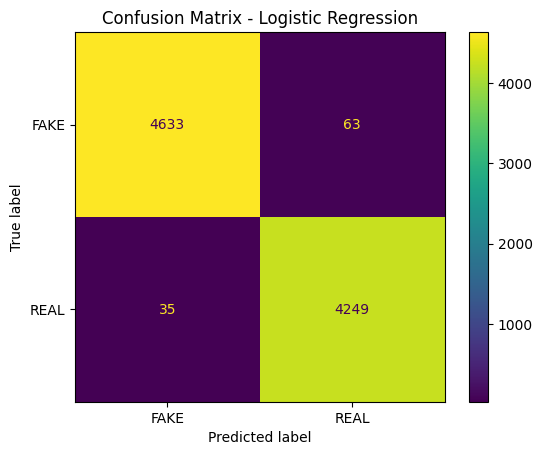

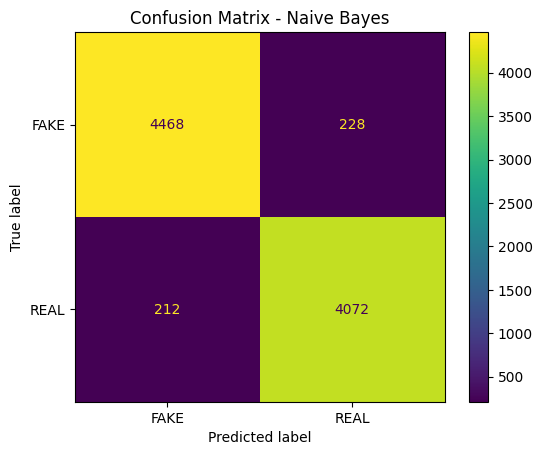

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
    disp.plot(values_format='d')
    plt.title(title)
    plt.show()

plot_cm(y_test, y_pred_lr, "Confusion Matrix - Logistic Regression")
plot_cm(y_test, y_pred_nb, "Confusion Matrix - Naive Bayes")

Comparison Between Multinomial Naive Bayes and Logistic Regression

**Overall Accuracy**

- Naive Bayes: ~95%

- Logistic Regression: ~99%

This means Logistic Regression achieved a significantly higher accuracy, reducing misclassifications by about 80% compared to Naive Bayes.

**Precision, Recall and F1-Score**

Naive Bayes:
- Precision: 0.95
- Recall: 0.95
- F1: 0.95

Logistic Regression:
- Precision: 0.99
- Recall: 0.99
- F1: 0.99


**Conclusion:**

Logistic Regression outperforms Naive Bayes in this fake news classification task because Logistic Regression has the ability to learn more complex (Writing style, phrasing and different word combinations) relationships in text and this leads to substantially higher accuracy and reliability.


### Informative Words
I analyze which words and phrases have the strongest influence on the Logistic Regression model's predictions.

In [15]:
feature_names = np.array(tfidf.get_feature_names_out())
coefs = log_reg.coef_[0]

# label 0 / 1 in encoder:
print("Classes (encoder order):", label_encoder.classes_)


class_for_positive = label_encoder.inverse_transform([1])[0]
class_for_negative = label_encoder.inverse_transform([0])[0]

top_n = 20

top_pos_idx = np.argsort(coefs)[-top_n:]
top_neg_idx = np.argsort(coefs)[:top_n]

print(f"Top {top_n} words indicative of '{class_for_positive}':")
print(feature_names[top_pos_idx])

print(f"\nTop {top_n} words indicative of '{class_for_negative}':")
print(feature_names[top_neg_idx])

Classes (encoder order): ['FAKE' 'REAL']
Top 20 words indicative of 'REAL':
['told reuters' 'comment' 'president barack' 'democratic' 'said statement'
 'presidential' 'minister' 'nov' 'monday' 'friday' 'tuesday' 'thursday'
 'reuters president' 'republican' 'wednesday' 'washington'
 'president donald' 'washington reuters' 'said' 'reuters']

Top 20 words indicative of 'FAKE':
['video' 'just' 'hillary' 'read' 'president trump' 'gop' 'image'
 'featured image' 'featured' 'obama' 'america' 'watch' 'wire' 'mr' 'like'
 'breaking' 'getty' 'com' 'getty images' 'american']


### Manual Testing
I created a function that allows me to enter custom text and see how the model classifies it. This demonstrates how the system can be applied to new, unseen news articles.

In [16]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def predict_news(text, model=log_reg):
    text_clean = clean_text(text)
    vec = tfidf.transform([text_clean])
    pred = model.predict(vec)[0]
    label = label_encoder.inverse_transform([pred])[0]
    return label

# Create a text area for input
text_input = widgets.Textarea(
    value='',
    placeholder='Paste your news article here...',
    description='News Article:',
    disabled=False,
    layout=widgets.Layout(width='80%', height='150px')
)

# Create a button for prediction
predict_button = widgets.Button(
    description='Predict Label',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict if the article is FAKE or REAL'
)

# Output widget to display results
output_area = widgets.Output()

# Define the function to call when the button is clicked
def on_button_clicked(b):
    with output_area:
        clear_output()
        if text_input.value.strip():
            prediction = predict_news(text_input.value)
            print(f"Predicted label: {prediction}")
        else:
            print("Please enter an article to predict.")

# Attach the function to the button's on_click event
predict_button.on_click(on_button_clicked)

# Display the widgets
display(text_input, predict_button, output_area)

Textarea(value='', description='News Article:', layout=Layout(height='150px', width='80%'), placeholder='Paste…

Button(button_style='success', description='Predict Label', style=ButtonStyle(), tooltip='Click to predict if …

Output()